In [105]:
import numpy as np
import pandas as pd
import seaborn as sns
import time
import warnings
import statistics
import fbprophet
from fbprophet import Prophet
import datetime as dt

from pandas import to_datetime
from numpy import unique
from matplotlib import pyplot as plt
from random import random
from math import sqrt
from scipy import stats
from sklearn.metrics import mean_absolute_error
from datetime import datetime
from scipy.stats import norm
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_predict
from pandas.plotting import autocorrelation_plot
from neuralprophet import NeuralProphet, set_log_level

# Prophet Model

Source: https://machinelearningmastery.com/time-series-forecasting-with-prophet-in-python/

The Prophet library is an open-source library designed for making forecasts for univariate time series datasets. It is easy to use and designed to automatically find a good set of hyperparameters for the model in an effort to make skillful forecasts for data with trends and seasonal structure by default.

# Getting data

In [83]:
heartrate_df = pd.read_csv ('.\Data\HEARTRATE_AUTO_1658994387948.csv', sep=',', header=0)

In [84]:
heartrate_df['date'] = pd.to_datetime(heartrate_df['date'],infer_datetime_format=True) #convert from string to datetime
heartrate_df['time'] = pd.to_datetime(heartrate_df['time'], format='%H:%M').dt.strftime("%H:%M")

heartrate_df['date'] = pd.to_datetime(heartrate_df['date'].astype(str)+' '+heartrate_df['time'].astype(str), format='%Y-%m-%d %H:%M')
heartrate_df['date'] = heartrate_df['date'].dt.strftime('%Y-%m-%d %H:%M')
heartrate_df = heartrate_df.drop(columns=['time'])

# generating the indexed dataset
indexed_dataset = heartrate_df.set_index(['date'])

In [85]:
starting_date = datetime.strptime(heartrate_df['date'].iloc[0], '%Y-%m-%d %H:%M').strftime("%Y-%m-%d")
end_date = datetime.strptime(heartrate_df['date'].iloc[-1], '%Y-%m-%d %H:%M').strftime("%Y-%m-%d")
print('Start date: {}\nEnd date: {}'.format(starting_date, end_date))

Start date: 2022-06-12
End date: 2022-06-19


In [86]:
# print version number
print('Prophet %s' % fbprophet.__version__)

Prophet 0.7.1


In [87]:
# prepare expected column names
df = heartrate_df.copy()
df.columns = ['ds', 'y']
df['ds']= to_datetime(df['ds'])

In [88]:
# define the model
model = Prophet()
# fit the model
model.fit(df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
C:\Users\apanico\Miniconda3\envs\football\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


# Make an In-Sample Forecast

A forecast is made by calling the predict() function and passing a DataFrame that contains one column named ‘ds‘ and rows with date-times for all the intervals to be predicted.

There are many ways to create this “forecast” DataFrame. In this case, we will loop over one year of dates, e.g. the last 12 months in the dataset, and create a string for each month. We will then convert the list of dates into a DataFrame and convert the string values into date-time objects.

In [89]:
# prepare training dataset
train_size = len(df) -331
train, test = df[0:train_size], df[train_size:]
history = [x for x in train]

In [90]:
# define the period for which we want a prediction
future = test['ds']
future = pd.DataFrame(future)
future.columns = ['ds']
future['ds']= to_datetime(future['ds'])

This DataFrame can then be provided to the predict() function to calculate a forecast.

The result of the predict() function is a DataFrame that contains many columns. Perhaps the most important columns are the forecast date time (‘ds‘), the forecasted value (‘yhat‘), and the lower and upper bounds on the predicted value (‘yhat_lower‘ and ‘yhat_upper‘) that provide uncertainty of the forecast.

For example, we can print the first few predictions as follows:

In [91]:
# use the model to make a forecast
forecast = model.predict(future)
# summarize the forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

C:\Users\apanico\Miniconda3\envs\football\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\apanico\Miniconda3\envs\football\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


                   ds       yhat  yhat_lower  yhat_upper
0 2022-06-19 01:45:00  54.056328   39.046789   69.427252
1 2022-06-19 01:47:00  53.998106   39.427872   69.140235
2 2022-06-19 01:49:00  53.943280   38.876862   69.119504
3 2022-06-19 01:51:00  53.891714   38.264344   68.423390
4 2022-06-19 01:53:00  53.843275   38.777123   68.822087


Prophet also provides a built-in tool for visualizing the prediction in the context of the training dataset.

This can be achieved by calling the plot() function on the model and passing it a result DataFrame. It will create a plot of the training dataset and overlay the prediction with the upper and lower bounds for the forecast dates.

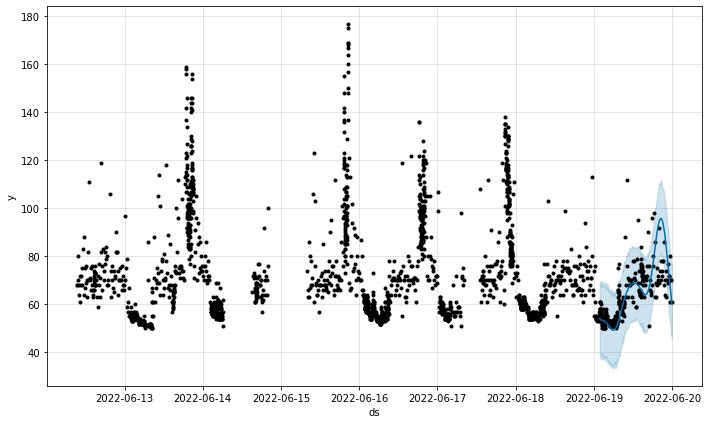

In [92]:
# plot forecast
model.plot(forecast)
plt.show()

Running the example forecasts the last day of the dataset.

The first five days of the prediction are reported and we can see that values are not too different from the actual heartrates values in the dataset.

Next, a plot is created. We can see the training data are represented as black dots and the forecast is a blue line with upper and lower bounds in a blue shaded area.

We can see that the forecasted 12 months is a good match for the real observations, especially when the bounds are taken into account.

# Make an Out-of-Sample Forecast

In practice, we really want a forecast model to make a prediction beyond the training data.

This is called an out-of-sample forecast.

We can achieve this in the same way as an in-sample forecast and simply specify a different forecast period.

In this case, a period beyond the end of the training dataset, starting 1969-01.

In [93]:
last_dataset_measure = df.iloc[-1].ds

In [94]:
start_time_prediction = last_dataset_measure
end_time_prediction = start_time_prediction + dt.timedelta(days=1)

#rounding to 10 t (usefull for the future)
future = pd.date_range(start= pd.Timestamp(start_time_prediction).round('10T'), end = pd.Timestamp(end_time_prediction).round('10T'), freq="10T")
future = start_times.strftime('%Y-%m-%d %H:%M').tolist()

C:\Users\apanico\Miniconda3\envs\football\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\apanico\Miniconda3\envs\football\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


                   ds       yhat  yhat_lower  yhat_upper
0 2022-06-20 00:00:00  59.601342   43.901027   74.557736
1 2022-06-20 00:10:00  57.869588   42.344579   72.811353
2 2022-06-20 00:20:00  56.295319   41.625030   71.531273
3 2022-06-20 00:30:00  54.883939   39.230238   69.547389
4 2022-06-20 00:40:00  53.637241   38.081522   68.753199


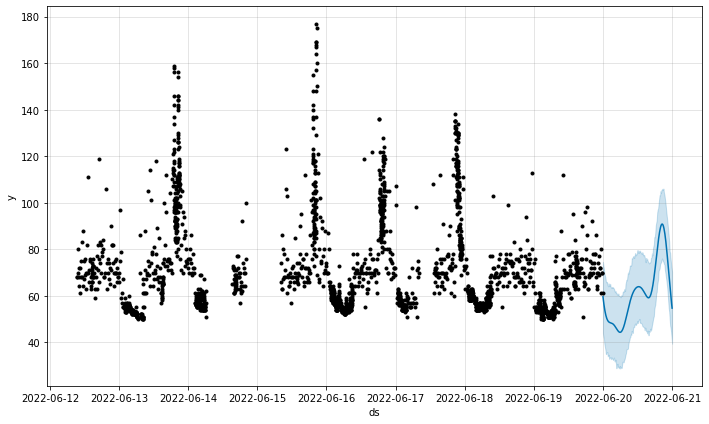

In [95]:
# define the period for which we want a prediction
future = pd.DataFrame(future)
future.columns = ['ds']
future['ds']= to_datetime(future['ds'])
# use the model to make a forecast
forecast = model.predict(future)
# summarize the forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
# plot forecast
model.plot(forecast)
plt.show()

Running the example makes an out-of-sample forecast for the heartrate data.

The first five rows of the forecast are printed, although it is hard to get an idea of whether they are sensible or not
A plot is created to help us evaluate the prediction in the context of the training data.

The new one-day forecast does look sensible, at least by eye

# Manually Evaluate Forecast Model

It is critical to develop an objective estimate of a forecast model’s performance.

This can be achieved by holding some data back from the model, such as the last 12 months. Then, fitting the model on the first portion of the data, using it to make predictions on the held-pack portion, and calculating an error measure, such as the mean absolute error across the forecasts. E.g. a simulated out-of-sample forecast.

The score gives an estimate of how well we might expect the model to perform on average when making an out-of-sample forecast.

We can do this with the samples data by creating a new DataFrame for training with the last 12 months removed.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
C:\Users\apanico\Miniconda3\envs\football\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\apanico\Miniconda3\envs\football\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\apanico\Miniconda3\envs\football\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_com

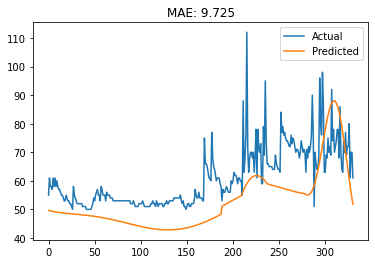

In [102]:
# define the model
model = Prophet()
# fit the model
model.fit(train)

# define the period for which we want a prediction
future = test['ds']
future = pd.DataFrame(future)
future.columns = ['ds']
future['ds']= to_datetime(future['ds'])

# use the model to make a forecast
forecast = model.predict(future)
# calculate MAE between expected and predicted values for the next day
y_true = df['y'][-len(test):].values
y_pred = forecast['yhat'].values
mae = mean_absolute_error(y_true, y_pred)
# plot expected vs actual
plt.title('MAE: %.3f' % mae)
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

Next, a mean absolute error is calculated for the forecast period.

Finally, a plot is created comparing the actual vs. predicted values. In this case, we can see that the forecast is not a good fit.


Work better on source:
![image.png](https://machinelearningmastery.com/wp-content/uploads/2020/02/Plot-of-Actual-vs.-Predicted-Values-for-Last-12-Months-of-Car-Sales.png)

# Improvement with neural prophet

Source: https://github.com/ourownstory/neural_prophet

## Generic forecast: Time-based features only

In this first section, we will train a model with time-features only like we would do with Facebook Prophet.

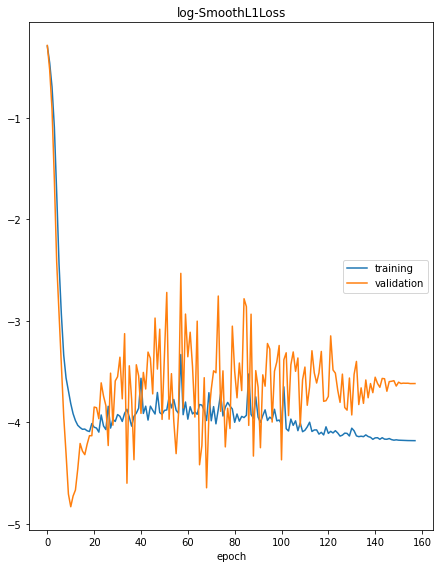

log-SmoothL1Loss
	training         	 (min:   -4.180, max:   -0.294, cur:   -4.180)
	validation       	 (min:   -4.830, max:   -0.289, cur:   -3.617)


In [120]:
m = NeuralProphet()
metrics = m.fit(train, freq='D', validation_df=test, progress='plot')

In [121]:
metrics.tail(1)

,SmoothL1Loss,MAE,RMSE,RegLoss,SmoothL1Loss_val,MAE_val,RMSE_val
157,0.015303,7.207737,11.540577,0.0,0.026857,14.035897,15.759941


INFO - (NP.df_utils._infer_frequency) - Major frequency 2T corresponds to 48.187% of the data.
INFO:NP.df_utils:Major frequency 2T corresponds to 48.187% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq D. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency 2T corresponds to 48.187% of the data.
INFO:NP.df_utils:Major frequency 2T corresponds to 48.187% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq D. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.


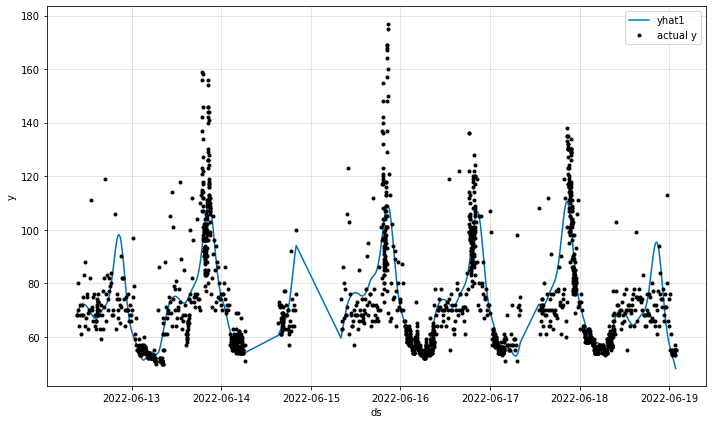

In [122]:
forecast = m.predict(train)
fig = m.plot(forecast)

INFO - (NP.df_utils._infer_frequency) - Major frequency 2T corresponds to 74.924% of the data.
INFO:NP.df_utils:Major frequency 2T corresponds to 74.924% of the data.
WARNING - (NP.df_utils._infer_frequency) - Defined frequency D is different than major frequency 2T
INFO - (NP.df_utils._infer_frequency) - Major frequency 2T corresponds to 74.924% of the data.
INFO:NP.df_utils:Major frequency 2T corresponds to 74.924% of the data.
WARNING - (NP.df_utils._infer_frequency) - Defined frequency D is different than major frequency 2T


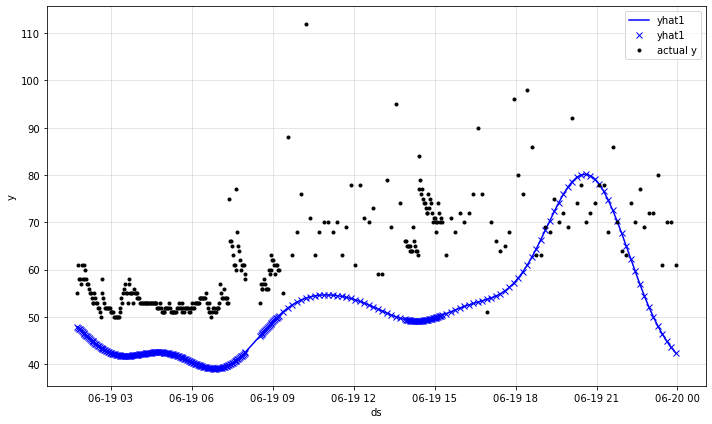

In [123]:
# Predict the test
forecast = m.predict(test)
m = m.highlight_nth_step_ahead_of_each_forecast(1)
fig = m.plot(forecast)

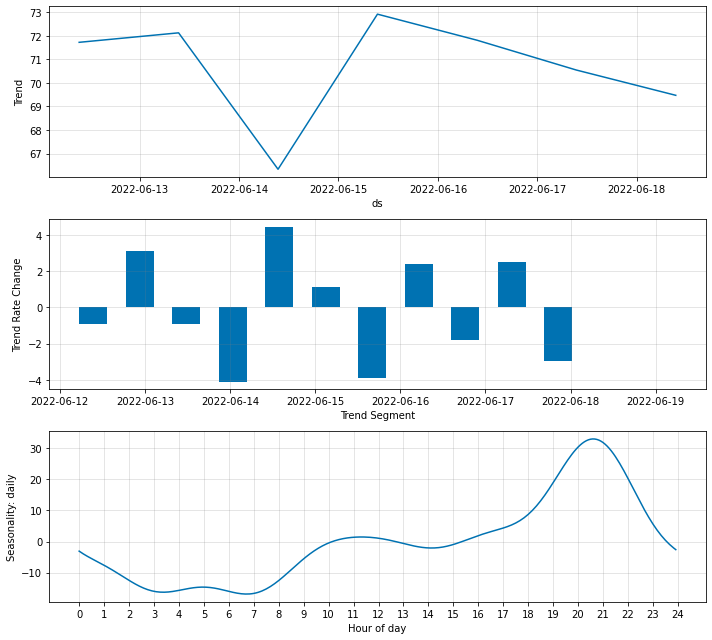

In [124]:
fig_param = m.plot_parameters()

# one-step ahead forecast with Auto-Regression


For now it cannot be done due to time irregularity of data sampling

In [139]:
m = NeuralProphet(
    growth='off',
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    n_lags=3*24,
    ar_reg=1,
    learning_rate = 0.01,
)

metrics = m.fit(train, freq='H', validation_df=test, progress='plot')

INFO - (NP.df_utils._infer_frequency) - Major frequency 2T corresponds to 48.187% of the data.
INFO:NP.df_utils:Major frequency 2T corresponds to 48.187% of the data.
WARNING - (NP.df_utils._infer_frequency) - The auto-frequency feature is not able to detect the following frequencies: SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS. If the frequency of the dataframe is any of the mentioned please define it manually.


ValueError: Detected multiple frequencies in the timeseries please pre-process data.

In [127]:
metrics.tail(1)

,SmoothL1Loss,MAE,RMSE,RegLoss,SmoothL1Loss_val,MAE_val,RMSE_val
157,0.053419,17.318231,21.951941,0.0,0.026329,13.698062,15.604218


INFO - (NP.df_utils._infer_frequency) - Major frequency 2T corresponds to 48.187% of the data.
INFO:NP.df_utils:Major frequency 2T corresponds to 48.187% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq D. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency 2T corresponds to 48.187% of the data.
INFO:NP.df_utils:Major frequency 2T corresponds to 48.187% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq D. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.


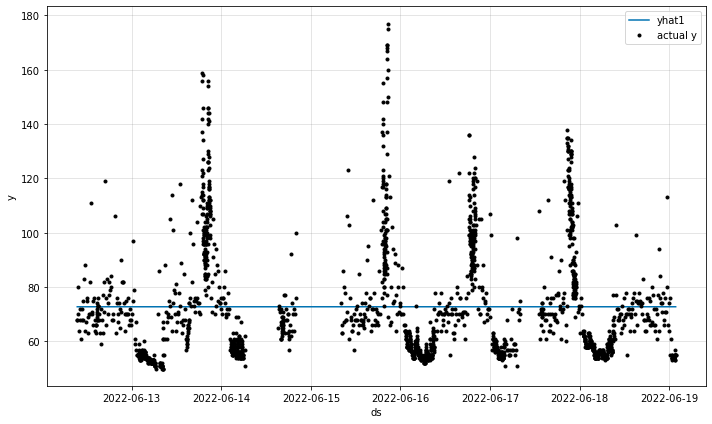

In [128]:
forecast = m.predict(train)
fig = m.plot(forecast)

# one step ahead forecast with AR-Net: Using a Neural Network


In [140]:
m = NeuralProphet(
    growth='off',
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    n_lags=3*24,
    num_hidden_layers=4,
    d_hidden=32,
    learning_rate=0.003,
)

metrics = m.fit(train, freq='H', validation_df=test, progress='plot')

INFO - (NP.df_utils._infer_frequency) - Major frequency 2T corresponds to 48.187% of the data.
INFO:NP.df_utils:Major frequency 2T corresponds to 48.187% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq H. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
INFO - (NP.forecaster.__handle_missing_data) - 111 NaN values in column y were auto-imputed.
INFO:NP.forecaster:111 NaN values in column y were auto-imputed.


ValueError: More than 30 consecutive missing values encountered in column y. 29 NA remain. Please preprocess data manually.